<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_ImageClassification_FinetuningVGG19_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import cv2
import shutil
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.applications import VGG19 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Dataset

### Download data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
dataset_folderpath = "/content/input"

In [ ]:
if os.path.isdir(dataset_folderpath):
  !rm -R {dataset_folderpath}

In [ ]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [ ]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz -C {dataset_folderpath}

# clear_output()

!ls {dataset_folderpath}

tar: /content/drive/My Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/DSFigureDataset.tar.gz: Cannot read: Input/output error
tar: At beginning of tape, quitting now
tar: Error is not recoverable: exiting now


### Split `train`, `val` and `test` dataset

The `zip` contains a script to generate the ml dataset

In [ ]:
% cd {dataset_folderpath}
!python setup.py

/content/input
Number of classes : 20
['RadarPlot', 'Table', 'LineGraph', 'BubbleChart', 'Signatures', 'AreaGraph', 'ScatterGraph', 'ParetoChart', 'Map', 'HorizontalBarGraph', 'PieChart', 'VennDiagram', 'TreeDiagram', 'VerticalBarGraph', 'FlowChart', 'NetworkDiagram', 'PersonPhoto', 'GeneralFigure', 'BoxPlot', 'GeneralPhoto']
RadarPlot: 
   > ntrain : 72
   > nval : 30
   > ntest : 2

Table: 
   > ntrain : 75
   > nval : 31
   > ntest : 2

LineGraph: 
   > ntrain : 91
   > nval : 37
   > ntest : 2

BubbleChart: 
   > ntrain : 65
   > nval : 28
   > ntest : 1

Signatures: 
   > ntrain : 72
   > nval : 30
   > ntest : 2

AreaGraph: 
   > ntrain : 121
   > nval : 51
   > ntest : 2

ScatterGraph: 
   > ntrain : 70
   > nval : 29
   > ntest : 1

ParetoChart: 
   > ntrain : 97
   > nval : 40
   > ntest : 2

Map: 
   > ntrain : 116
   > nval : 48
   > ntest : 2

HorizontalBarGraph: 
   > ntrain : 112
   > nval : 46
   > ntest : 2

PieChart: 
   > ntrain : 137
   > nval : 57
   > ntest : 2

Ve

In [ ]:
input_folder = "/content/input/dataset"

trn_folder = os.path.join(input_folder,"train")
val_folder = os.path.join(input_folder,"val")
test_folder = os.path.join(input_folder,"test")

In [ ]:
classes = [name for name in os.listdir(trn_folder) 
      if os.path.isdir(os.path.join(trn_folder,name))]
print(f"Number of classes : {len(classes)}")
print(classes)

Number of classes : 20
['RadarPlot', 'Table', 'LineGraph', 'BubbleChart', 'Signatures', 'AreaGraph', 'ScatterGraph', 'ParetoChart', 'Map', 'HorizontalBarGraph', 'PieChart', 'VennDiagram', 'TreeDiagram', 'VerticalBarGraph', 'FlowChart', 'NetworkDiagram', 'PersonPhoto', 'GeneralFigure', 'BoxPlot', 'GeneralPhoto']


In [ ]:
# Output of script
total_test=38

### Data preparation

Train and Val files are distributed in each folder with subfolders by class:

```
 folder\
    cls1\
        image.png
        image2.jpeg
        image3.png
        ...
    cls2\
        imageA.jpeg
        imageB.jpg
        imageC.png
        ...
    ...
```

We resize all the images to the same size.

In [ ]:
IMG_HEIGHT = 550
IMG_WIDTH = 550
batch_size = 4

In [ ]:
# With transform
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=trn_folder,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1969 images belonging to 20 classes.


In [ ]:
total_train=1969

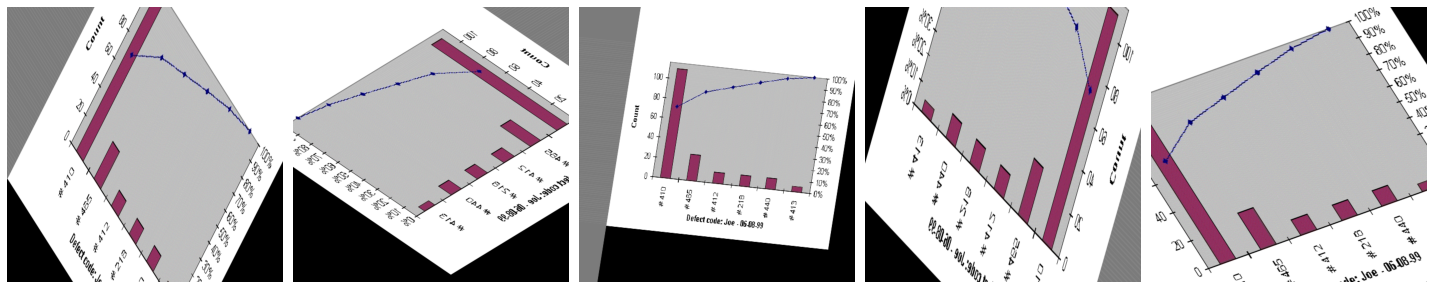

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_folder,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 818 images belonging to 20 classes.


In [ ]:
total_val=818

The `test` dataset is a list of images in a folder without associated label.

In [ ]:
test_images = []
shape = (IMG_HEIGHT,IMG_WIDTH)

for filename in os.listdir(test_folder):
  img = cv2.imread(os.path.join(test_folder,filename))

  # Resize all images to a specific shape
  img = cv2.resize(img,shape)

  test_images.append(img)
        
# Converting test_images to array
test_images = np.array(test_images)

## Model

In [ ]:
#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
#Defining the VGG Convolutional Neural Net
base_model = VGG19(include_top = False, weights = 'imagenet', input_shape = (IMG_HEIGHT,IMG_WIDTH,3), classes = len(classes))

In [ ]:
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

In [ ]:
#Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 17, 17, 512)       20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 147968)            0         
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Adding the Dense layers along with activation and batch normalization
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(len(classes),activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 17, 17, 512)       20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 147968)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              151520256 
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [ ]:
#Initializing the hyperparameters
batch_size=batch_size
epochs=10
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training the model
model.fit_generator(
    train_data_gen,
    epochs=50,
    steps_per_epoch=total_train // batch_size,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=[lrr], verbose = 1)

Epoch 1/50
492/492 [==============================] - 807s 2s/step - loss: 2.9806 - accuracy: 0.1191 - val_loss: 2.5829 - val_accuracy: 0.1275
Epoch 2/50
492/492 [==============================] - 793s 2s/step - loss: 2.9336 - accuracy: 0.1272 - val_loss: 2.7468 - val_accuracy: 0.1302
Epoch 3/50
492/492 [==============================] - 789s 2s/step - loss: 2.9274 - accuracy: 0.1267 - val_loss: 3.0774 - val_accuracy: 0.1278
Epoch 4/50
492/492 [==============================] - 790s 2s/step - loss: 2.9234 - accuracy: 0.1277 - val_loss: 2.7352 - val_accuracy: 0.1278
Epoch 5/50
492/492 [==============================] - 790s 2s/step - loss: 2.9238 - accuracy: 0.1277 - val_loss: 3.0030 - val_accuracy: 0.1253
Epoch 6/50
492/492 [==============================] - 789s 2s/step - loss: 2.9222 - accuracy: 0.1272 - val_loss: 3.0093 - val_accuracy: 0.1339
Epoch 7/50
492/492 [==============================] - 789s 2s/step - loss: 2.9242 - accuracy: 0.1282 - val_loss: 2.9039 - val_accuracy: 0.1229

In [ ]:
#Plotting the training and validation loss and accuracy
f,ax=plt.subplots(2,1) 

#Loss
ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

#Accuracy
ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:
#Making prediction
y_pred=model.predict_classes(x_test)
y_true=np.argmax(y_test,axis=1)